# High Frequence Data and Limit Order Book - Lab5

Mian Zhang \
CentraleSuupélec

## 0. imports and data loading

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.stats
from scipy.interpolate import CubicSpline
import os
import Hawkes as hk

%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
path = "/content/drive/MyDrive/TOTF.PA/"
l = os.listdir(path)
dfs = []
for name in l:
    if "trades" in name:
        dfs += [pd.read_csv(path+name)]
        dfs[-1]["ts"] = pd.to_datetime(dfs[-1]["ts"])
        dfs[-1]["time_in_s"] = pd.to_datetime(dfs[-1]["ts"]).dt.hour*3600 + pd.to_datetime(dfs[-1]["ts"]).dt.minute*60 + pd.to_datetime(dfs[-1]["ts"]).dt.second + pd.to_datetime(dfs[-1]["ts"]).dt.microsecond/1000000
        dfs[-1]["one"] = 1
        dfs[-1].drop_duplicates(["ts"],inplace = True)

## 1. Experiments with the Hawkes library

In [11]:
T = dfs[0]["time_in_s"].to_numpy()
itv = [T[0],T[-1]]

In [12]:
model = hk.estimator()
model.set_kernel("exp",num_exp = 5)
model.set_baseline("plinear",num_basis = 6)
model.fit(T,itv)
print("parameter:",model.parameter) # the estimated parameter values
print("branching ratio:",model.br) # the branching ratio
print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
print("AIC:",model.AIC) # the AIC of the estimated parameter values

parameter: {'mu': array([0.04380056, 0.0490833 , 0.02469096, 0.02190248, 0.02966271,
       0.04601551]), 'alpha': array([0.04235405, 0.08444662, 0.17233789, 0.15131215, 0.18015638]), 'beta': array([5.67282099e+01, 1.28283327e+00, 1.11341909e-02, 1.01256254e-01,
       5.67282138e+01])}
branching ratio: 0.6306070800114463
log-likelihood: -6921.348139811807
AIC: 13848.696279623615


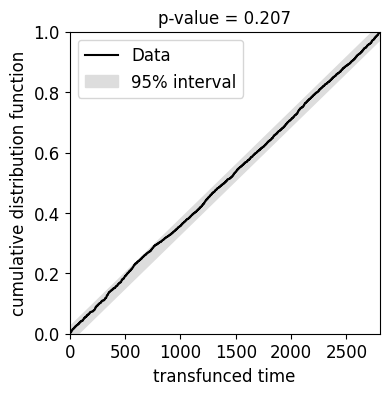

In [13]:
model.plot_KS()

In [14]:
[T_trans, itv_trans] = model.t_trans() 

In [15]:
T_trans_norm = T_trans/itv_trans[1]

In [16]:
scipy.stats.kstest(T_trans_norm, "uniform")[1]

0.20663941468430336

We checked that the p-value shown in the plot_KS method is indeed the p-value of a KS test of the transfunced times against a uniform distribution.

## 2. Systematic analysis

In [17]:
def test_model(model):
    [T_trans, itv_trans] = model.t_trans()
    T_trans_norm = T_trans/itv_trans[1]
    return scipy.stats.kstest(T_trans_norm, "uniform")[1]

In [18]:
#exps = [i for i in range(1,9)]
#samples = [0.25*2**i for i in range(6)]
#basis = [i for i in range(2,7)]
#pvals = np.zeros((len(exps),len(samples),len(basis),len(dfs)))
#aics = np.zeros((len(exps),len(samples),len(basis),len(dfs)))
#brs = np.zeros((len(exps),len(samples),len(basis),len(dfs)))
#for day in range(len(dfs)):
#    df = dfs[day]
#    Ttot = df["time_in_s"].to_numpy()
#    for i in range(len(exps)):
#        for j in range(len(samples)):
#            for k in range(len(basis)):
#                df_resampled = df.resample(str(samples[j])+"H",on = "ts").first()
#                T = Ttot[Ttot-Ttot[0]<samples[j]*3600]
#                itv = [T[0],T[-1]]
#                model = hk.estimator()
#                model.set_kernel("exp",num_exp = exps[i])
#                model.set_baseline("plinear",num_basis = basis[k])
#                model.fit(T,itv)
#                p = test_model(model)
#                pvals[i,j,k,day] = p
#                aics[i,j,k,day] = model.AIC
#                brs[i,j,k,day] = model.br
#results = np.zeros((3,len(exps),len(samples),len(basis),len(dfs)))
#results[0] = pvals
#results[1] = aics
#results[2] = brs
#np.save("DHF-LAB5-ZHANG-MARCHISET-Results.npy",results)

In [20]:
results = np.load("/content/drive/MyDrive/DHF-LAB5-ZHANG-Results.npy")

In [21]:
exps = [i for i in range(1,9)]
samples = [0.25*2**i for i in range(6)]
basis = [i for i in range(2,7)]
pvals = results[0]
aics = results[1]
brs = results[2]

In [22]:
np.sum(np.ones_like(pvals)[pvals>0.9])/(len(exps)*len(samples)*len(basis)*len(dfs))

0.07784090909090909

To test for goodness of fit, we used a KS test for a uniformly distributed variable on the transfuced times. Higher p-values indicate good fit, and we used a threshold of 0.9. The test is passed 7% of the time, which indicates rather poor goodness of fit.

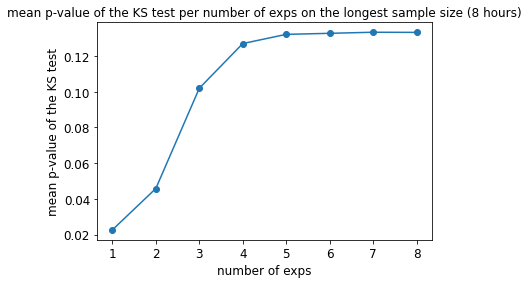

In [23]:
fig,ax = plt.subplots()
ax.plot(exps,np.mean(pvals,axis = (2,3))[:,-1])
ax.scatter(exps,np.mean(pvals,axis = (2,3))[:,-1])
ax.set_xlabel("number of exps")
ax.set_ylabel("mean p-value of the KS test")
ax.set_title("mean p-value of the KS test per number of exps on the longest sample size (8 hours)");

As expected, the p-value of the KS test increases with the numbr of exponential kernels on longer samples, which indicates a better fit. The highest p-value remains small (around 0.13), which could be explained by the fact that we averaged on all the value of number of linear pieces in the baseline.

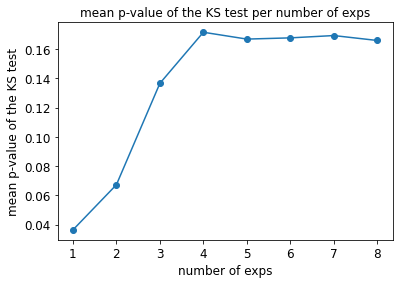

In [24]:
fig,ax = plt.subplots()
ax.plot(exps,np.mean(pvals,axis = 3)[:,-1,-1])
ax.scatter(exps,np.mean(pvals,axis = 3)[:,-1,-1])
ax.set_xlabel("number of exps")
ax.set_ylabel("mean p-value of the KS test")
ax.set_title("mean p-value of the KS test per number of exps");

Using only the highest value of number of linear pieces in the baseline allows to reach better goodness of fit as expected.

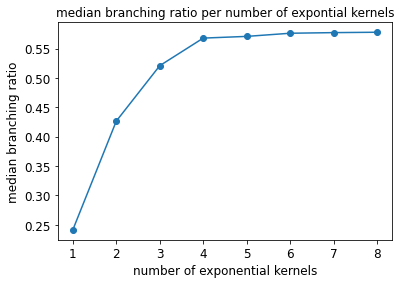

In [25]:
fig,ax = plt.subplots()
ax.plot(exps,np.median(brs,axis = (1,2,3)))
ax.scatter(exps,np.median(brs,axis = (1,2,3)))
ax.set_xlabel("number of exponential kernels")
ax.set_ylabel("median branching ratio")
ax.set_title("median branching ratio per number of expontial kernels");

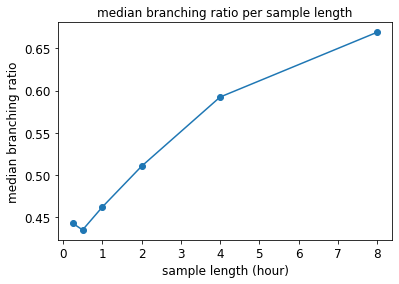

In [26]:
fig,ax = plt.subplots()
ax.plot(samples,np.median(brs,axis = (0,2,3)))
ax.scatter(samples,np.median(brs,axis = (0,2,3)))
ax.set_xlabel("sample length (hour)")
ax.set_ylabel("median branching ratio")
ax.set_title("median branching ratio per sample length");

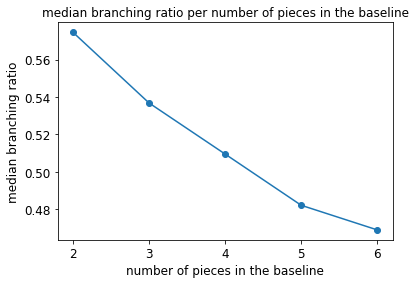

In [27]:
fig,ax = plt.subplots()
ax.plot(basis,np.median(brs,axis = (0,1,3)))
ax.scatter(basis,np.median(brs,axis = (0,1,3)))
ax.set_xlabel("number of pieces in the baseline")
ax.set_ylabel("median branching ratio")
ax.set_xticks(basis)
ax.set_title("median branching ratio per number of pieces in the baseline");

Branching ratio increases with the number of kernels (which is not surprising since adding kernels adds terms to the sum in the definition of the branching ratio), and with the sample length (which probably means that when the sample length gets too high, the baseline intensity has to be low enough to accomodate for the least active parts of the day, and the remaining activity has to be added with endogeneity). It decreases with the number of pieces in the baselines, which further coroborates this last point, as more pieces means that the model can acomodate with the more and less active parts of the day with the baseline.

In [28]:
min_aic = np.argmin(aics,axis = 0)+1

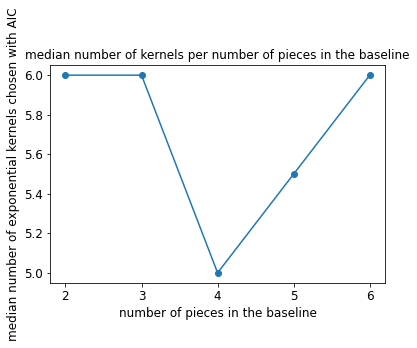

In [29]:
fig,ax = plt.subplots()
ax.plot(basis,np.median(min_aic,axis =(0,2)))
ax.scatter(basis,np.median(min_aic,axis =(0,2)))
ax.set_xlabel("number of pieces in the baseline")
ax.set_xticks(basis)
ax.set_ylabel("median number of exponential kernels chosen with AIC")
ax.set_title("median number of kernels per number of pieces in the baseline");

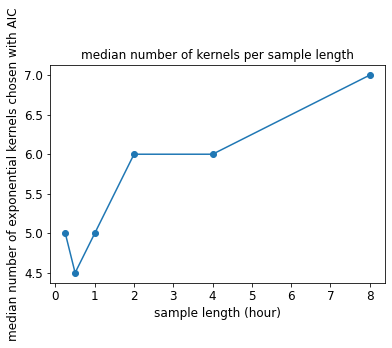

In [30]:
fig,ax = plt.subplots()
ax.plot(samples,np.median(min_aic,axis =(1,2)))
ax.scatter(samples,np.median(min_aic,axis =(1,2)))
ax.set_xlabel("sample length (hour)")
ax.set_ylabel("median number of exponential kernels chosen with AIC")
ax.set_title("median number of kernels per sample length");

The number of kernels chosen with the AIC does not seem to depend on the number of pieces in the baseline. However, it clearly increases with the sample length, which further proves the firts point of this section that longer sample length require more kernels.